**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job! The project is accepted. Good luck on the final sprint!

# Project description
The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.
in order to fight churn, Model Fitness has digitized a number of its customer profiles. Your task is to analyze them and come up with a customer retention strategy.

# Business Goal
* Learn to predict the probability of churn (for the upcoming month) for each customer
* Draw up typical user portraits: Select the most outstanding groups and describe their main features
* Analyze the factors that impact churn most
* Draw basic conclusions and develop recommendations on how to improve customer service

# Data Sources
Model Fitness provided you with CSV files containing data on churn for a given month and information on the month preceding it.
-------------------------User data for the preceding month--------------------------------

* 'Churn' — the fact of churn for the month in question
* 'gender'
* 'Near_Location' — whether the user lives or works in the neighborhood where the gym is located
* 'Partner' — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
* Promo_friends — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
* 'Phone' — whether the user provided their phone number
* 'Age'
* 'Lifetime' — the time (in months) since the customer first came to the gym

-----------Data from the log of visits and purchases and data on current membership status-----------
* 'Contract_period' — 1 month, 3 months, 6 months, or 1 year
* 'Month_to_end_contract' — the months remaining until the contract expires
* 'Group_visits' — whether the user takes part in group sessions
* 'Avg_class_frequency_total' — average frequency of visits per week over the customer's lifetime
* 'Avg_class_frequency_current_month' — average frequency of visits per week over the preceding month
* 'Avg_additional_charges_total' — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, roc_auc_score,\
    precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import itertools
import warnings
warnings.filterwarnings('ignore')

## Step Download the data 

In [2]:
df =pd.read_csv('/datasets/gym_churn_us.csv')

##  Carry out exploratory data analysis (EDA)

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Most of the variables are binary and won't need any additional changes. Here is a rough summary:
  * Roughly equally divided by gender
  * Users are mostly in their 20s. Ages range from 18 to 41 (average = 29 / standard dev = 3).
  * Average user stays with the gym for 3 months before churning
  * Low visits: Average user visits the gym 2 times per week
Of special note are the near location (84%) and phone (90%) variables of which given their binary value are heavily skewed. We'll keep this in mind as we might need to drop them--won't provide as much info. and might distort result.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great!

</div>

In [4]:
def modifyChart(ax,
                columnLabel,
                labelSize,
                titleSize=False,
                maxs=False,
                xLabel='',
                yLabel=''):
    """
    Function that takes in graph variables for the purpose of customizing 
    their default settings (ie. setting label size)
    """
    if titleSize != False:
        ax.set_title(columnLabel,
                     fontsize=titleSize,
                     fontweight='semibold',
                     pad=10)
    else:
        ax.set_title(columnLabel)

    # spines
    sns.despine()
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('lightgrey')

    # labels
    ax.set_ylabel(yLabel, labelpad=5, fontsize=16)
    ax.set_xlabel(xLabel, labelpad=5, fontsize=16)

    # tick settings
    ax.tick_params(labelsize=labelSize)
    ax.tick_params(axis='both', left=False, bottom=False)
    ax.grid(axis='y', alpha=.4)

    # if a max value is passed
    if maxs:
        midCenterQuarter = (ax.get_yticks()[1] - ax.get_yticks()[0]) / 4  # to ensure that the tick labels don't overlap
        
        ax.set_ylim(0, maxs)  # set the yticks
        # keep all except last  tick - ensure that the ticks don't overlap
        # add the last tick value
        y_ticks = np.append(
            [i for i in ax.get_yticks() if i < (maxs - midCenterQuarter)],[maxs])
        # set the modified y ticks
        ax.set_yticks(y_ticks)

# Plots: Exploring Variables
Plotting binary variables using bar plots.

In [5]:
binary = [col for col in df.columns if df[col].nunique() <= 2]
len(binary)

7

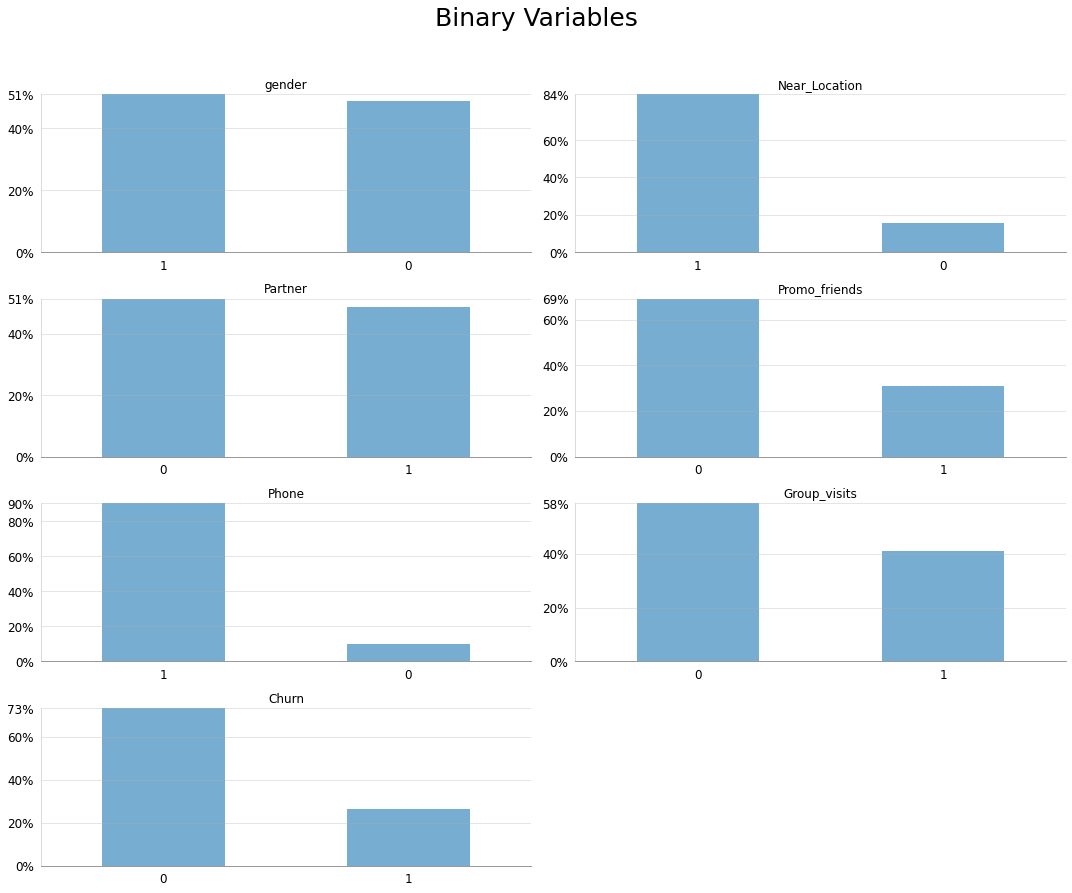

In [6]:
fig, ax = plt.subplots(figsize=(15, 12), ncols=2, nrows=4)

axes = [(row, col) for row in range(4) for col in range(2)]

for col, i in zip(binary, axes):
    #unique values and their counts per column (normalized -> %)
    toChart = df[col].value_counts(normalize=True)
    #bar plot
    toChart.plot.bar(ax=ax[i], rot=0, alpha=.6)
    #calculate maximum value
    maxs = max(df[col].value_counts(normalize=True))
    #modify chart
    modifyChart(ax[i], col, 12, maxs=maxs)
    #set y tick values in % format
    ax[i].set_yticklabels(
        ["{}%".format(int(i * 100)) for i in ax[i].get_yticks()[:]])

#turn off the last chart value as it's empty
plt.suptitle('Binary Variables',fontsize=25,y=1.03)
ax[axes[-1]].axis('off')
plt.tight_layout()

 **Per the graph:**

 * 58% of users take part in group sessions
 * 84% live or work near the neighborhood
 * Roughly 50% are an employee of a partner company.
 * 1/3 signed up through a "bring a friend" offer
 
In addition, it looks like the phone variable will not be needed given it's overwhelming 1 relative value as well as it's low relevancy to the target variable. We'll tolerate the location variables as it has > 15% of values placed in the least common unique value and might provided some useful info (it's expected that the closer the gym location, the less the churn rate)..

In [7]:
df.drop(columns='Phone',inplace=True)

In [8]:
nonBinary = [col for col in df.columns if df[col].nunique() > 2]
len(nonBinary)

7

(0.0, 1.0, 0.0, 1.0)

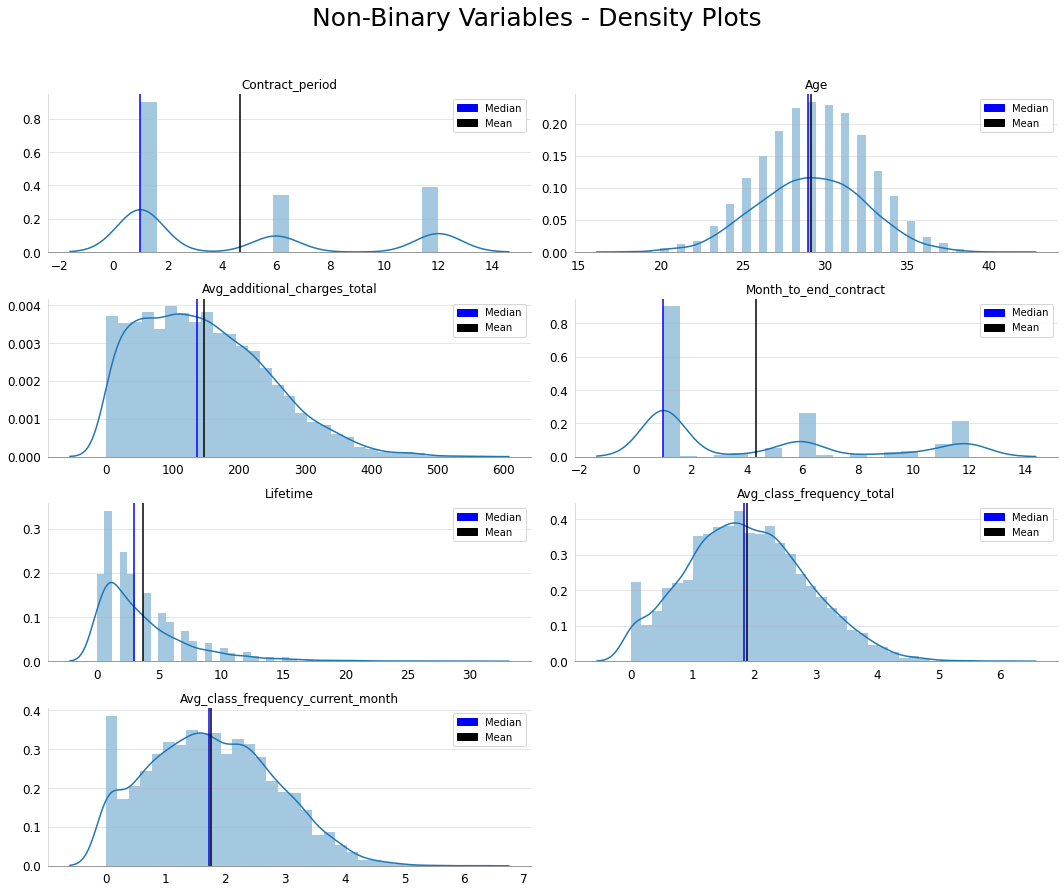

In [9]:
fig, ax = plt.subplots(figsize=(15, 12), ncols=2, nrows=4)

axes = [(row, col) for row in range(4) for col in range(2)]

for col, i in zip(nonBinary, axes):
    sns.distplot(df[col], ax=ax[i])
    modifyChart(ax[i], col, 12)

    ax[i].axvline(df[col].median(), color='blue')
    ax[i].axvline(df[col].mean(), color='black')

    #referring to axes in order to use the pyplot module
    plt.sca(ax[i])
    #custom legend
    azure_patch = mpatches.Patch(color='blue', label='Median')
    orange_patch = mpatches.Patch(color='black', label='Mean')
    plt.legend(handles=[azure_patch, orange_patch])
plt.suptitle('Non-Binary Variables - Density Plots',fontsize=25,y=1.03)
plt.tight_layout()
ax[axes[-1]].axis('off')

**Summary of the graphs:**

* Most users are relatively new: Roughly half of users have 4 months or less with the company with some long time users having stayed as member for 12 to 30 months as indicated in the right tail of the distribution.
* Month to end contract and contract period tell the same story especially considering that:
* 85% of users have 1 month contract

* Avg. weekly visits for current month and lifetime seem to have high correlations with each other. This makes sense as most users have 1 month contracts.

# Plots: Features vs. Independent


In [10]:
len(df.columns)

13

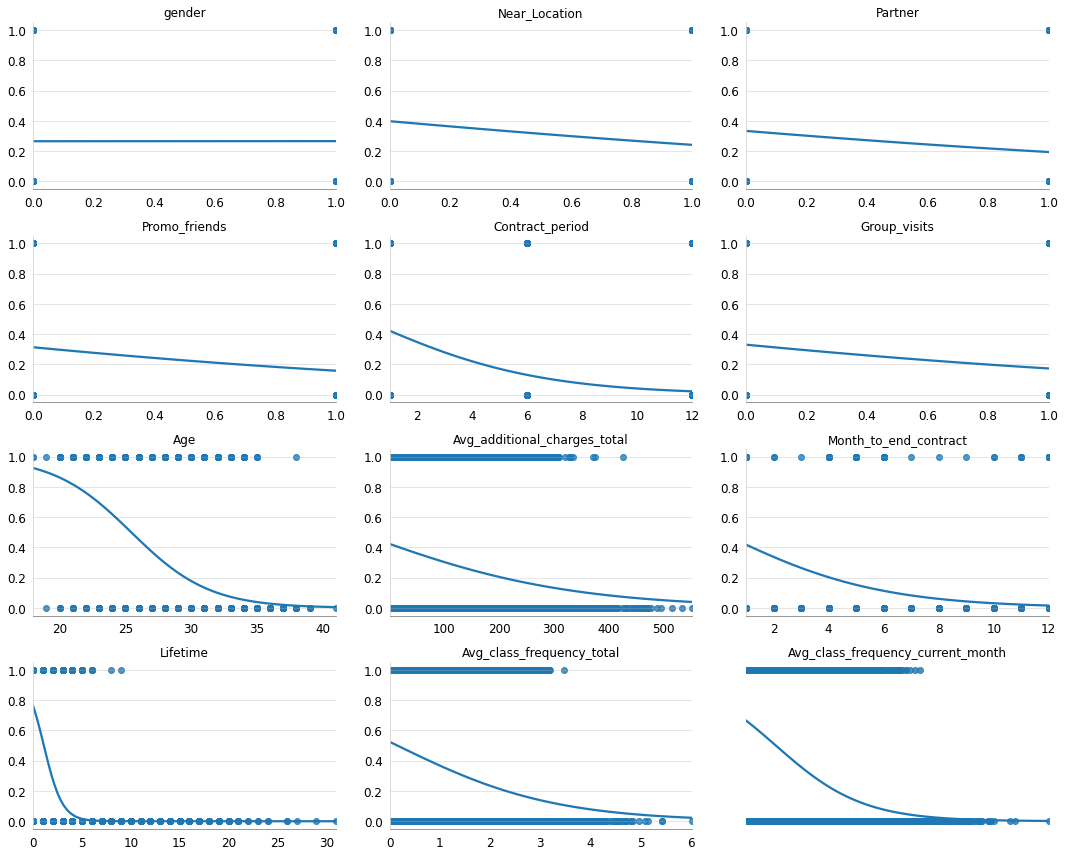

In [11]:
fig, ax = plt.subplots(figsize=(15, 12), ncols=3, nrows=4)

axes = [(row, col) for row in range(4) for col in range(3)]

#dropping target variable column
for col, i in zip(df.drop('Churn', axis=1).columns, axes):
    #skipping this column -> displayed value counts in x axis
    if col == 'avgWeeklyVisitsCurrentMonth': continue

    #logist regression plots
    sns.regplot(df[col], df['Churn'], ci=None, logistic=True, ax=ax[i])
    modifyChart(ax[i], col, 12)

ax[axes[-1]].axis('off')
plt.tight_layout()

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, you explored the data on the whole a bit before comparing the two groups!

</div>

# Bar Histograms - Churn vs No Churn Variable comparisons

In [12]:
toChart = df.groupby("Churn").mean()

#how many columns and unique values
print(len(toChart.columns))
print(toChart.index)

12
Int64Index([0, 1], dtype='int64', name='Churn')


In [13]:
toChart = toChart.rename(index={0:'No Churn',1:"Churn"})
toChart

,gender,Near_Location,Partner,Promo_friends,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,
No Churn,0.510037,0.873086,0.534195,0.353522,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
Churn,0.510839,0.768143,0.355325,0.183789,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


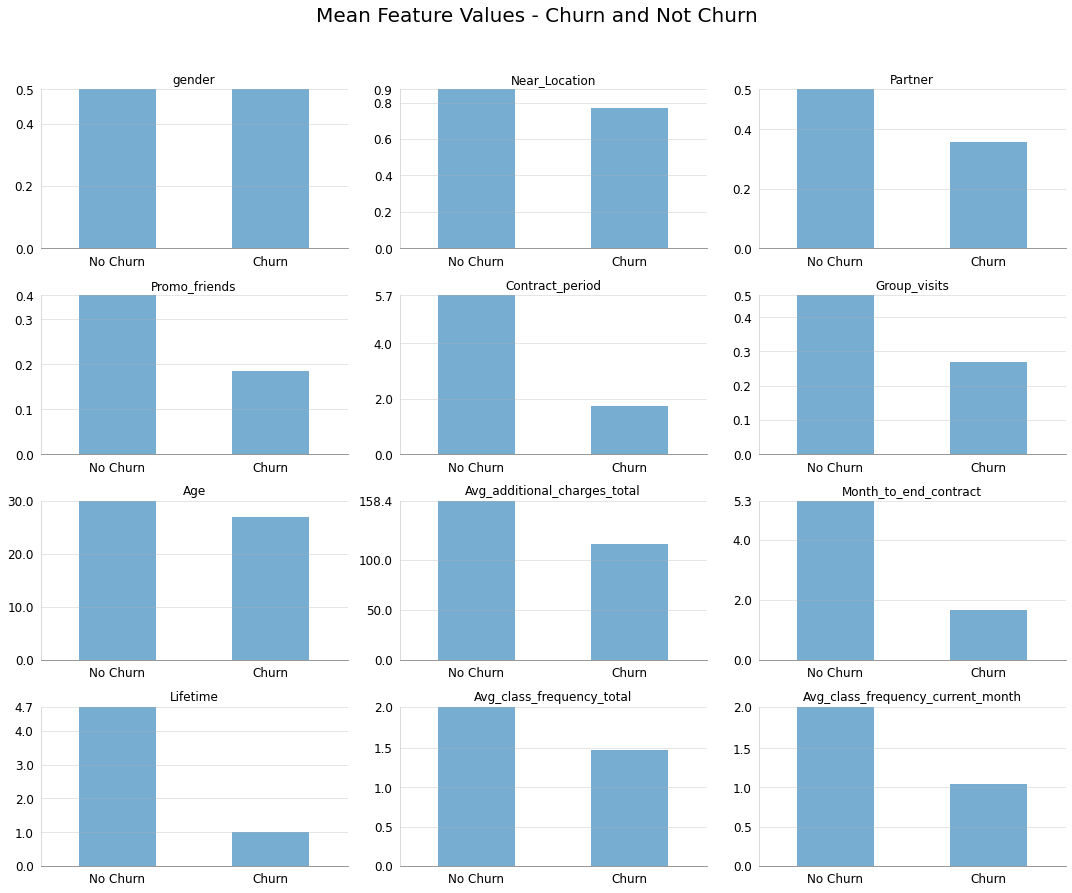

In [14]:
fig, ax = plt.subplots(figsize=(15, 12), ncols=3, nrows=4)
axes = [(row, col) for row in range(4) for col in range(3)]

for col, i in zip(toChart.columns, axes):
    toChart[col].plot.bar(ax=ax[i], rot=0, alpha=.6)

    maxs = max(toChart[col])
    modifyChart(ax[i], col, 12, maxs=maxs)

    ax[i].set_yticklabels(["{:.1f}".format(i) for i in ax[i].get_yticks()])

plt.suptitle("Mean Feature Values - Churn and Not Churn", fontsize=20, y=1.03)
plt.tight_layout()


we start seeing some interesting patterns. Relative to no churn, churn users are:

- less likely to be an employee from a partner company
- less likely to enroll through a promotions program
- less likely to come from group visits
- spend less in additional charges

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Good, you compared the two groups and made some interesting observations! For non-binary features we could get a closer look at the feature distributions in the two groups ([example](https://seaborn.pydata.org/tutorial/distributions.html#conditioning-on-other-variables))

</div>

Correlation Matrix


In [15]:
df.corr().head()

,gender,Near_Location,Partner,Promo_friends,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
gender,1.000000,0.006699,-0.010463,-0.005033,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
Near_Location,0.006699,1.000000,-0.005119,0.210964,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
Partner,-0.010463,-0.005119,1.000000,0.451960,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
Promo_friends,-0.005033,0.210964,0.451960,1.000000,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
Contract_period,0.000502,0.150233,0.306166,0.244552,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984


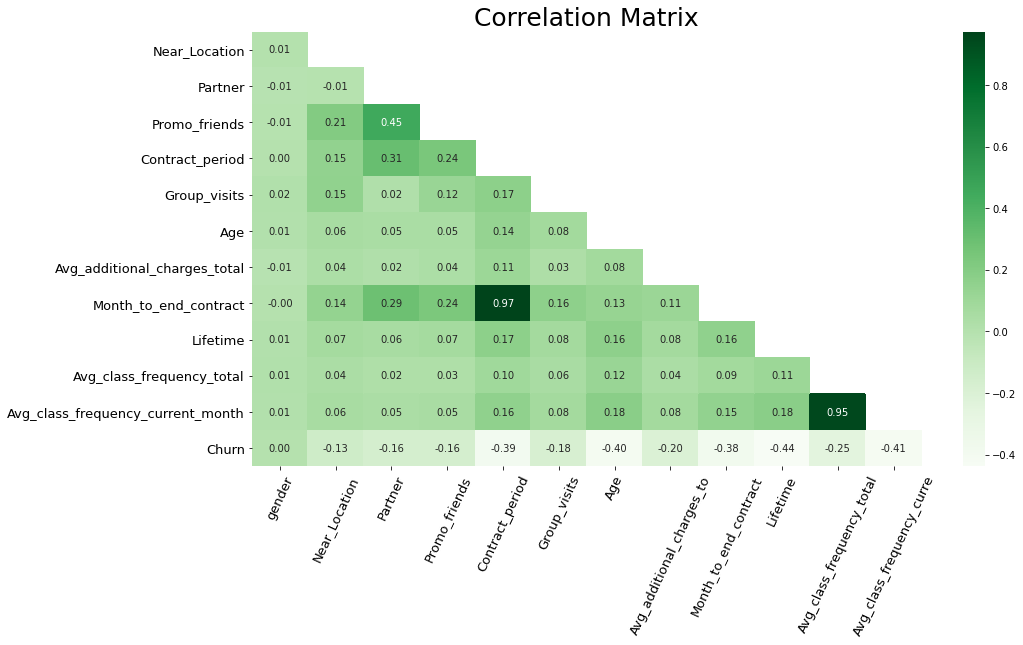

In [16]:
fig, ax = plt.subplots(figsize=(15, 8))

#boolean mask to not diplay duplicatre half
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

sns.heatmap(df.corr(), annot=True, cmap='Greens', mask=mask, fmt='.2f')
#get y limits
bottom, top = ax.get_ylim()
#set y limit and skip last value (empty)-- same for x axis
ax.set_ylim(bottom, 1)
ax.tick_params(labelsize=13)
left, right = ax.get_xlim()
ax.set_xlim(left, right - 1)

#retrieve and show the first 25 characters
ax.set_xticklabels([i.get_text()[:25] for i in ax.get_xticklabels()])
ax.tick_params(axis='x', labelrotation=65)
plt.title("Correlation Matrix",fontsize=25)
plt.show()

We see an inverse relationship between the feature variables and target variable.

We also see multicollinearity (> 90%) between weekly visits lifetime and current months as well as contract period and month to end contract variables. As mentioned, this is most likely due to the overwhelming (85%) of users who have one-month contracts. Also notice the 0 Pearson correlation coefficient indicating no relationship between the the target variable--it's safe to drop.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Good points! Although you've got to be careful about interpreting 0 correlation as no relationship: it only means there is no linear relation. Consider, for example, a random variable $X$ uniformly disributed on $[-1, 1]$, and $Y = X^2$. Then correlation of $X$ and $Y$ is 0, but there is a clear functional relationship

</div>

In [17]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [18]:
df.drop(columns = ['Month_to_end_contract','gender'],inplace=True)
df.head()

,Near_Location,Partner,Promo_friends,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,6,1,29,14.227470,3,0.020398,0.000000,0
1,1,0,0,12,1,31,113.202938,7,1.922936,1.910244,0
2,1,1,0,1,0,28,129.448479,2,1.859098,1.736502,0
3,1,1,1,12,1,33,62.669863,2,3.205633,3.357215,0
4,1,1,1,1,0,26,198.362265,3,1.113884,1.120078,0


##  Build a model to predict user churn

In [19]:
# divide the data into features (the X matrix) and a target variable (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=0)

In [20]:
# define the model's algorithm
lr_model = LogisticRegression(random_state=0)

# training model
lr_model.fit(X_train, y_train)
# binary prediction
lr_predictions = lr_model.predict(X_test)
# using the trained model to make forecasts
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

In [21]:
RandomForestClassifier()

RandomForestClassifier()

Random state set to 0. For the remaining parameters of the tree (its depth max_depth, the size of the feature subset max_features, and the minimum number of objects per node min_samples_leaf), we left the default values unchanged.

In [22]:
# defining the new model's algorithm based on the random forest algorithm
rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
#fitting the model  with training datra
rf_model.fit(X_train, y_train)

# use the trained model to make predictions
rf_predictions = rf_model.predict(X_test)  #binary
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]  #ratio

In [23]:
# define the function that will output metrics
def print_all_metrics(y_true, y_pred, y_proba, title='Classification metrics'):
     
   
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [24]:
# set the threshold  (due to unbalanced set)
threshold = .4

# calculate prediction on the basis of probabilities and the ratio between classes
custom_predictions = [0 if i < threshold else 1 for i in lr_probabilities]

In [25]:
# print all studied metrics for the resulting prediction
print_all_metrics(y_test,
                  lr_predictions,
                  lr_probabilities,
                  title='Metrics for logistic regression (50% Ratio):')
print()
print_all_metrics(y_test,
                  custom_predictions,
                  lr_predictions,
                  title='Metrics for logistic regression (40% Ratio):')

Metrics for logistic regression (50% Ratio):
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97

Metrics for logistic regression (40% Ratio):
	Accuracy: 0.92
	Precision: 0.82
	Recall: 0.87
	F1: 0.84
	ROC_AUC: 0.89


In [26]:
print_all_metrics(y_test,
                  rf_predictions,
                  rf_probabilities,
                  title='Metrics for random forest:')

Metrics for random forest:
	Accuracy: 0.92
	Precision: 0.86
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


 The metrics of special interest would have to be in focusing on catching potential churn members and adding incentives to keep them as members. In addition, those who are more likely to churn will be given the extra attention rather than those with relatively lower risks of churning. As such, reducing the false positive rates will be the metric in choosing the best fit model for the task at hand--focusing on intervention for high-risk churners.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were trained and evaluated correctly. Conclusion makes sense!

</div>

 **Per the metrics, the most fitting model will therefore be the Logistic Regression one at it's standard 50% threshold.**

In [27]:
def plot_confusion_matrix(cm,
                          labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(cm,
                cmap=cmap,
                annot=True,
                square=True,
                fmt='.0f',
                annot_kws={"fontsize": 15})

    #title and tick labels
    plt.title(title, pad=20, fontsize=20)
    ax.set_yticklabels(labels, fontsize=13)
    ax.set_xticklabels(labels, fontsize=13)

    #label chart settings
    plt.ylabel('Label', labelpad=15, fontsize=17)
    plt.xlabel('Predicted label', labelpad=15, fontsize=17)
    plt.show()

# Final Model

In [28]:
# defining the new model's algorithm based on the logistic regression
final_model = LogisticRegression(random_state=0)
final_model.fit(X_train, y_train)

# use the trained model to make predictions
final_predictions = final_model.predict(X_test)
final_probabilities = final_model.predict_proba(X_test)[:, 1]

In [29]:
print_all_metrics(y_test,
                  final_predictions,
                  final_probabilities,
                  title='Metrics for random forest:')

Metrics for random forest:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


Confusion matrix, without normalization


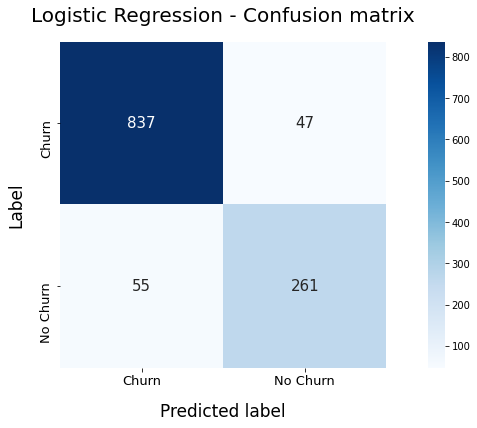

In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, lr_predictions)

plot_confusion_matrix(cnf_matrix,
                      normalize=False,
                      labels=['Churn', 'No Churn'],
                      title='Logistic Regression - Confusion matrix')

<div class="alert alert-success">
<b>Reviewer's comment</b>

A confusion matrix is a good tool for examining classification models! 

</div>

[4.3238538]


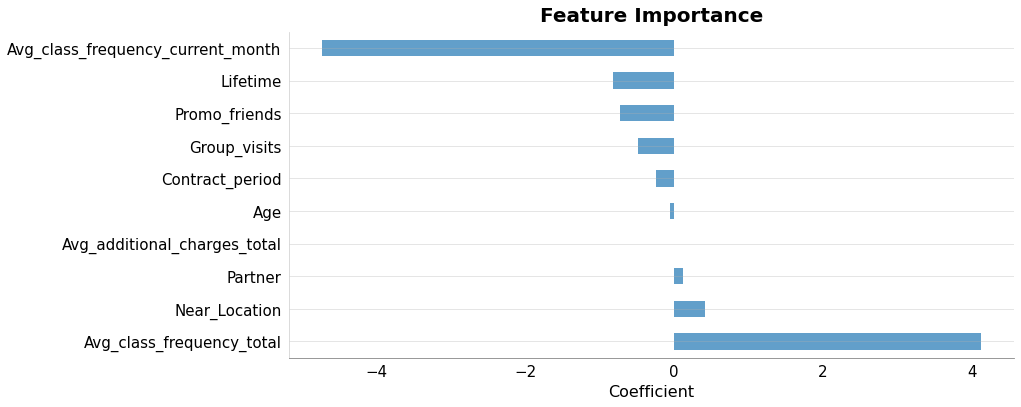

In [31]:
# print y intercept
print(final_model.intercept_)
# creating a DataFrame with feature names and importance
fi_df = pd.DataFrame(data={
    'feature': X.columns,
    'importance': final_model.coef_[0]
}).sort_values('importance', ascending=False)

# horizontal bar chart
ax = fi_df.plot.barh(figsize=(13, 6), alpha=.7, legend=False)
ax.set_yticklabels([i for i in fi_df['feature'].values])
modifyChart(ax, 'Feature Importance', 15, titleSize=20)
plt.xlabel("Coefficient")
plt.show()

Less chance of churning:

- avg weekly visits per current month
- lifetime  (longer time with company)
- group visits
- promo friends
- contract period

<div class="alert alert-warning">
<b>Reviewer's comment</b>

It's nice that you looked at the weights of the model, although due to multicollinearity (`avg_class_frequency_current_month` and `avg_class_frequency_total` are highly correlated), they are not as reliable as we'd like 

</div>

**User Clusters**


In [ ]:
#standardization of data before passing it to the algorithm
sc = StandardScaler()
X_sc = sc.fit_transform(X)
#matrix of distances based on the standardized feature matrix
linked = linkage(X_sc, method='ward')

In [ ]:
plt.figure(figsize=(15, 10))

#dendogram -> hierarchical clustering treemap
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for Customers')
plt.show()

Using 5 clusters to create the groups via the K-Means algorithm.

In [ ]:
km = KMeans(n_clusters=5)  # setting the number of clusters as 5
labels = km.fit_predict(
    X_sc)  # applying the algorithm to the data and forming a cluster vector

# store cluster labels in the field of our dataset
df['customerCluster'] = labels

# print the statistics of the mean feature values per cluster
paired = df.groupby('customerCluster').mean()
paired

<div class="alert alert-warning">
<b>Reviewer's comment</b>

I suggest setting `random_state` of KMeans to make your research reproducible: otherwise clusters can be slightly different every time you run the code due to random initialization of cluster centers

</div>

0 an 1 lowest chance of churning as well as 4



In [ ]:
# silhouette score for the clustering
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Uers in clusters have some overlapping features. Plotting mean feature values to get a better view of the clusters.

In [ ]:
# mean feature values for clusters.
fig, ax = plt.subplots(figsize=(15, 12), ncols=2, nrows=5)
axes = [(row, col) for row in range(5) for col in range(2)]

for col, i in zip(df.drop('Churn', axis=1).columns, axes):
    # groupby feature ignored
    if 'customerCluster' in col:
        continue

    # to check if  one unqie value in grouped columns
    check = list(df.groupby('customerCluster').agg({col: 'nunique'}).values)
    # if so or if unique columns  values are less than 3
    if 1 in check or df[col].nunique() <= 3:
        # than bar plot
        df.groupby('customerCluster').agg({ col: 'mean' }).plot.bar(ax=ax[i], legend=False)
        modifyChart(ax[i], col, 10)
        continue

    # else create a facet grid to display mutliple  distribution plots within one graph
    g = sns.FacetGrid(data=df, hue='customerCluster')
    g.map(sns.distplot, col, hist=False, rug=True, ax=ax[i])

    # chart modifications
    [ax[i].spines[spine].set_visible(False) for spine in ['top', 'right']]
    modifyChart(ax[i], col, 10)
    plt.close()
plt.suptitle("Mean Feature Values Per Cluster",fontsize=25,y=1.03)
ax[axes[-1]].axis('off')
plt.tight_layout()

* Cluster 3 users are way more likely to come through a partner company as well be referred through a friend promotion. In addition their contracts are on average 8 months.
* Seems like company partners yields a great opportunity due to social nature of fellow employees going to the gym a indicated by the friend promotion prob. and partner company employees probabilities.
* Users from cluster 1 all took part of a group session.
* Cluster 0 users have the next longest contract at 6 months. In addition, as indicated by their distributions, they are also most likely to take on additional charges, have higher weekly visits, have a much higher lifetime, and are a little older than the other cluster users.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
#chart with added series for the purposes of diplaying a bar showing aggregate churn rate
df.groupby('customerCluster').agg({
    'Churn': 'mean'
}).append(pd.Series(df['Churn'].mean(), index=('Churn', ),
                    name='All')).sort_values(
                        'Churn', ascending=False).plot.bar(ax=ax,
                                                           alpha=.6,
                                                           rot=0,
                                                           legend=False)

maxs = max([category.get_height() for category in ax.patches])
modifyChart(ax, col, 13, maxs=maxs, xLabel='Cluster', yLabel='Churn Rate (%)')

ax.set_yticklabels(["{}%".format(int(i * 100)) for i in ax.get_yticks()[:]])
ax.set_title('Churn', fontsize=18, pad=15)
plt.show()

Cluster 2,3, and 3 users are the most likely to churn and should be of interest to the company.

In [ ]:
# heatmap across column
paired.sort_values('Churn',
                   ascending=False).transpose().style.background_gradient(
                       cmap='Greens', axis=1)

* Across the board, the following features as previously shown in our model, decrease the chances of churning the higher their values are:
* Total charge, employee of a partner company, longer term contract,promotion though friend, and lifetime in months
* Interestingly enough, users coming from clusters with a relatively high churn rate (> 40%) on average last 2 month with the gym. Considering the higher values, for the other clusters, the 2nd month of a cluster will be of interest to the company in terms of customer engagement.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Clusters were identified and studied successfully!

</div>

# Conclusions and Recommendations
Based on the previous findings as well as some external reports, here are some recommendations for improving customer retention and churn:

1. Company should place an emphasis on fostering group interaction activities such as group classes. This is especially the case for the customer profile seen earlier(average age 29) since according to fitness reports , studies are showing the effectiveness of group classes in improving retention rate for fitness studios for those in the younger generation (see 1 and 2).
2. The second month of a user's lifetime should be of special importance to the company. Of those identified at high risk, offer specialized discounts in addition to reaching out to them. (see 3).
3. Create stronger relationships with users who identified as having less chances of churning (coming from partner company or those with > 1 month contract). Offer better discounts or packages for both and continue engagement (see 4 and 5).

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Recommendations make sense and are consistent with the data! I didn't get what the references like 'see 1' are to though 🤔

</div>